**Step 001 Data cleaning(necessary and important),The data of 4 cities and 2 formats for 2 months requires 4 cores of 32G + 1 V100 for a total of 6 hours(screenshot shown in the end of code) . When the actual project is implemented, daily data can be stored and stored. Cleaning is pre-processed to change the model training prediction lead time to 0.(PS:Download on the server offer by the match organization is prohibit,so the effect of code is only can be showed by screenshot of running on server.)**

**1.Use IQR (interquartile method) to remove outliers (instead of null values) through a single cell to avoid the impact of sudden failures and clusters.
2.Fill in missing values by week shift.Fill in missing values by day shift that are still missing.Fill in the median value of the entire city at the same time for those still missing.**

**数据清理部分(必要且重要），4个地市2种制式2个月数据需要耗费4核32G + 1 V100共计6小时(参见代码最后截图)，在实际项目落地时可通过日常数据的随存随清洗进行预处理，将模型训练预测前置时间变为0。（备注：因赛事方比赛服务器限制所有下载，部分代码效果只有对服务器代码运行截图显示，参见代码部分。）**

**1.通过单个小区应用IQR（四分位差法）去除异常值（替代为空值），避免突发故障及群聚的影响。
2.1）按周平移填充缺失值；2）仍然缺失的按天平移填充缺失值；3）仍然缺失的使用整个城市同时间中位值填充。**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import math
import pickle

In [ ]:
start_time = datetime.datetime.now()
log_str = 'start_time is {}'.format(start_time)
print(log_str)

**the start time of code running**
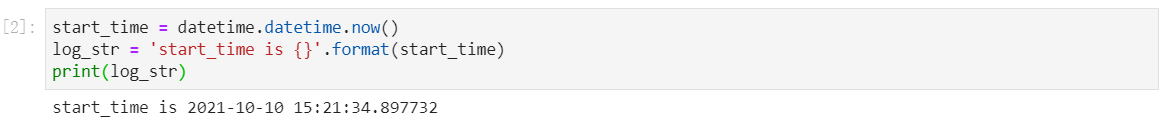

In [ ]:
city_list = ['C48FDFBFC4072E0E','AFE97F546A10368F','EA5EAA705108BDA0','F37F452354AC87C9']
fileFolder = './compdata/4G5G_Data/Train_Data'
timestamp_column = "TimeStamp"
userlabel_column = "UserLabel"
G4_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
G5_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
data_time_format = "%Y-%m-%d %H:%M:%S"

In [ ]:
nettype_name_dict = {'4g':set(),'5g':set()}
city_name_dict = {}
for city in city_list:
    city_name_dict[city] = set()
monthname_dict = {}
for month in range(1,7):
    monthname_dict[month] = set()

In [ ]:
for folderName,subfolders,filenames in os.walk(fileFolder):
    for filename in filenames:
        if "/Train_Data/Train_Data" not in folderName and filename.endswith('.csv'):
            file_path = os.path.join(folderName,filename)
            nettype_ins = filename[:2]
            city_ins = filename[-20:-4]
            month_ins = int(filename[11])
            nettype_name_dict[nettype_ins].add(file_path)
            city_name_dict[city_ins].add(file_path)
            monthname_dict[month_ins].add(file_path)

**1.Use IQR (interquartile method) to remove outliers (instead of null values) through a single cell to avoid the impact of sudden failures and clusters.
2.Fill in missing values by week shift.Fill in missing values by day shift that are still missing.Fill in the median value of the entire city at the same time for those still missing.**

In [ ]:
def fill_cicle_all(input_data,userlabel_column = "UserLabel",timestamp_column = "TimeStamp",drop_time_orgin = True,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH'],
                   time_format = "%Y/%m/%d %H:%M",days_shift = 1,time_shift = datetime.timedelta(seconds=900)):
    input_data = input_data.query("{}.notnull()".format(timestamp_column))
    input_data.loc[:,"TimeStamp_orgin"] = input_data[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
    time_all = input_data["TimeStamp_orgin"].unique()
    all_timestamp = list(set(input_data[timestamp_column]))
    start_time_point = datetime.datetime.strptime(all_timestamp[0],time_format)
    last_time_point = datetime.datetime.strptime(all_timestamp[-1],time_format)
    for timestamp_point_str in all_timestamp:
        timestamp_point = datetime.datetime.strptime(timestamp_point_str,time_format)
        if start_time_point > timestamp_point:
            start_time_point = timestamp_point
        if last_time_point < timestamp_point:
            last_time_point = timestamp_point
    time_len = (last_time_point -start_time_point)/time_shift + 1
    time_len = int(time_len)
    print("This data time_length is:",time_len)
    all_timestamp = {start_time_point.strftime(time_format)}
    print(all_timestamp)
    for time_point in range(time_len):
        timestamp_point = start_time_point + time_point * time_shift
        all_timestamp.add(timestamp_point.strftime(time_format))
    print(len(all_timestamp))
    all_timestamp = list(all_timestamp)
    all_userlabel = list(input_data[userlabel_column].unique())
    timestamp_pddata = pd.DataFrame([all_timestamp,['all'] * len(all_timestamp)],index = [timestamp_column,'join_key']).T
    userlabel_pddata = pd.DataFrame([all_userlabel,['all'] * len(all_userlabel)],index = [userlabel_column,'join_key']).T
    alljoin_pddata = timestamp_pddata.merge(userlabel_pddata,on = 'join_key')
    alljoin_pddata.loc[:,"TimeStamp_orgin"] = alljoin_pddata[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
    print(len(alljoin_pddata))
    input_data = pd.concat([input_data,alljoin_pddata])
    input_data = input_data.drop_duplicates([userlabel_column,"TimeStamp_orgin"])
    del(alljoin_pddata)
    #input_data = input_data.drop(["TimeStamp_orgin",'join_key'],axis = 1)
    input_data = input_data.drop('join_key',axis = 1)
    print("now the input_data length is {}".format(len(input_data)))
    #input_data.reset_index(drop = True,inplace = True)
    input_data['hour'] = input_data['TimeStamp_orgin'].apply(lambda x: x.hour)
    input_data.sort_values(['hour','UserLabel','TimeStamp'],inplace = True)
    input_data.reset_index(drop = True,inplace = True)
    days_len = int(time_len/24)
    print("This data days_len is:",days_len)
    for col_name in data_columns:
        X_col = input_data[col_name].values.reshape(-1,days_len)
        """
        mean_col = np.nanmean(X_col,axis = 1)
        std_col = np.nanstd(X_col,axis = 1)
        low_limit = np.repeat(mean_col - std_col * 4,days_len).reshape(X_col.shape)
        high_limit = np.repeat(mean_col + std_col * 4,days_len).reshape(X_col.shape)
        """
        Q1_col = np.percentile(X_col, 25, axis = 1)
        Q3_col = np.percentile(X_col, 75, axis = 1)
        IQR_col = Q3_col - Q1_col
        low_limit = np.repeat(Q1_col - IQR_col * 1.5,days_len).reshape(X_col.shape)
        high_limit = np.repeat(Q3_col + IQR_col * 1.5,days_len).reshape(X_col.shape)
        print('{}_low_limit num is {}'.format(col_name,(X_col < low_limit).sum()))
        print('{}_high_limit num is {}'.format(col_name,(X_col > high_limit).sum()))
        X_col[X_col > high_limit] = np.nan
        X_col[X_col < low_limit] = np.nan
        input_data[col_name] = X_col.flatten()
    input_data = input_data.drop("hour",axis = 1)
    cicle_num = math.ceil((last_time_point - start_time_point) / datetime.timedelta(days = days_shift))
    print('the fill cicle is {}'.format(cicle_num))
    for cicle_order in range(cicle_num):
        ('begin {} time cicle fill'.format(cicle_order))
        if len(data_columns) > 1:
            na_condition = input_data[data_columns].isnull().sum().sum()
        else:
            na_condition = input_data[data_columns].isnull().sum()
        if na_condition > 0:
            print('start {} time cicle fill'.format(cicle_order + 1))
            input_data = fill_same_time(input_data,userlabel_column = userlabel_column,timestamp_column = timestamp_column,
                       data_columns =data_columns,time_format = time_format,days_shift = days_shift)
            print('success {} time cicle fill'.format(cicle_order + 1))
        else:
            print('no need begin {} time cicle fill'.format(cicle_order + 1))
            break
    cicle_num = 4
    print('the second fill cicle is {}'.format(cicle_num))
    for cicle_order in range(cicle_num):
        ('begin {} time cicle fill'.format(cicle_order))
        if len(data_columns) > 1:
            na_condition = input_data[data_columns].isnull().sum().sum()
        else:
            na_condition = input_data[data_columns].isnull().sum()
        if na_condition > 0:
            print('start {} time cicle fill'.format(cicle_order + 1))
            input_data = fill_same_time(input_data,userlabel_column = userlabel_column,timestamp_column = timestamp_column,
                       data_columns =data_columns,time_format = time_format,days_shift = 1)
            print('success {} time cicle fill'.format(cicle_order + 1))
        else:
            print('no need begin {} time cicle fill'.format(cicle_order + 1))
            break
    if drop_time_orgin == True:
        input_data = input_data.drop('TimeStamp_orgin',axis = 1)
    return input_data

In [ ]:
def fill_same_time(input_data,userlabel_column = "UserLabel",timestamp_column = "TimeStamp",orgintime_be = True,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH'],
                   time_format = "%Y/%m/%d %H:%M",days_shift = 1,time_shift = datetime.timedelta(seconds=900)):
    print("all fill columns_list is",data_columns)
    orgin_columns = input_data.columns
    if orgintime_be == False:
        input_data.loc[:,"TimeStamp_orgin"] = input_data[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
    compare_columns = list(data_columns.copy())
    compare_columns.append(userlabel_column)
    #compare_columns.append("TimeStamp_orgin")
    new_compare_columns = []
    for new_col_name in data_columns:
        new_compare_columns.append('{}_compare'.format(new_col_name))
    new_compare_columns.append(userlabel_column)
    new_compare_columns.append("TimeStamp_orgin")
    #该段是用days_shift前的数据填充
    input_data_compare = input_data[compare_columns].copy()
    input_data_compare.loc[:,'TimeStamp_orgin'] = input_data['TimeStamp_orgin'] + datetime.timedelta(days = -days_shift)
    input_data_compare.columns = new_compare_columns
    input_data = input_data.merge(input_data_compare,on = ['UserLabel','TimeStamp_orgin'],how = 'left')
    for col_name in data_columns:
        fill_condition = input_data[col_name].isnull()
        input_data.loc[fill_condition,col_name] = input_data.loc[fill_condition,'{}_compare'.format(col_name)]
    orgin_columns_trans = list(orgin_columns.copy())
    if orgintime_be == False:
        orgin_columns_trans.append("TimeStamp_orgin")
    input_data = input_data[orgin_columns_trans]
    #该段是用days_shift前的数据填充
    input_data_compare = input_data[compare_columns].copy()
    input_data_compare.loc[:,'TimeStamp_orgin'] = input_data['TimeStamp_orgin'] + datetime.timedelta(days = days_shift)
    input_data_compare.columns = new_compare_columns
    input_data = input_data.merge(input_data_compare,on = [userlabel_column,'TimeStamp_orgin'],how = 'left')
    for col_name in data_columns:
        fill_condition = input_data[col_name].isnull()
        input_data.loc[fill_condition,col_name] = input_data.loc[fill_condition,'{}_compare'.format(col_name)]
    input_data = input_data[orgin_columns]
    return input_data

In [ ]:
def fill_time_radio(input_data,userlabel_column = "UserLabel",timestamp_column = "TimeStamp",orgintime_be = False,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH'],
                   time_format = "%Y/%m/%d %H:%M"):
    print("all fill columns_list is",data_columns)
    if len(data_columns) > 1:
        na_condition = input_data[data_columns].isnull().sum().sum()
    else:
        na_condition = input_data[data_columns].isnull().sum()
    if na_condition > 0:
        if orgintime_be == False:
            orgin_columns = input_data.columns
        else:
            orgin_columns = input_data.columns
            orgin_columns = orgin_columns.drop("TimeStamp_orgin")
        print('There is some data to fill')
        if orgintime_be == False:
            input_data.loc[:,"TimeStamp_orgin"] = input_data[timestamp_column].apply(lambda x: datetime.datetime.strptime(x,time_format))
        time_avr_data = input_data.groupby("TimeStamp_orgin")[data_columns].mean()
        user_avr_data = input_data.groupby(userlabel_column)[data_columns].mean()
        all_avr = input_data[data_columns].mean()
        user_avr_data = user_avr_data/all_avr
        user_avr_columns = []
        time_avr_columns = []
        for new_col_name in data_columns:
            user_avr_columns.append('{}_radio'.format(new_col_name))
            time_avr_columns.append('{}_time_avr'.format(new_col_name))
        user_avr_data.columns = user_avr_columns
        time_avr_data.columns = time_avr_columns
        #user_avr_data['all_radio'] = user_avr_data.mean(axis = 1)
        user_avr_data.reset_index(inplace = True)
        input_data = input_data.merge(user_avr_data,on = userlabel_column,how = 'left')
        input_data = input_data.merge(time_avr_data,on = "TimeStamp_orgin",how = 'left')
        for col_name in data_columns:
            fill_condition = input_data[col_name].isnull()
            if fill_condition.sum() > 0:
                print('now fill data of {} by cell {}_radio'.format(col_name,col_name))
                input_data.loc[fill_condition,col_name] = (input_data.loc[fill_condition,'{}_time_avr'.format(col_name)] *
                                                           input_data.loc[fill_condition,'{}_radio'.format(col_name)])
            else:
                continue
            fill_condition = input_data[col_name].isnull()
            if fill_condition.sum() > 0:
                print('now fill data of {} by cell all_radio'.format(col_name))
                """
                input_data.loc[fill_condition,col_name] = (input_data.loc[fill_condition,'{}_time_avr'.format(col_name)] *
                                                           input_data.loc[fill_condition,'all_radio'.format(col_name)])
                """
                input_data.loc[fill_condition,col_name] = input_data.loc[fill_condition,'{}_time_avr'.format(col_name)]
            else:
                continue
            fill_condition = input_data[col_name].isnull()
            if fill_condition.sum() > 0:
                print('there is error lead to fill fail ,maybe a cell have no any data')
        input_data = input_data[orgin_columns]
    else:
        print('perfect data')
        if orgintime_be == True:
            input_data = input_data.drop("TimeStamp_orgin",axis = 1)
    return input_data

In [ ]:
def minus_trans(input_data,col_name = "上行利用率PUSCH",trans_value = np.nan):
    minus_condition = (input_data[col_name] < 0)
    input_data.loc[minus_condition,col_name] = trans_value
    return input_data
def max_trans(input_data,col_name = "上行利用率PUSCH",max_value = 100,trans_value = np.nan):
    minus_condition = (input_data[col_name] > max_value)
    input_data.loc[minus_condition,col_name] = trans_value
    return input_data

In [ ]:
def g4_minus_trans(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']):
    for col_name in data_columns:
        input_data  = minus_trans(input_data,col_name)
    return input_data

def g5_minus_trans(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']):
    for col_name in data_columns:
        input_data  = minus_trans(input_data,col_name)
    return input_data

In [ ]:
def g4_max_trans_berfore(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH'],
                   max_value_list = [100,100,100]):
    for i in range(len(data_columns)):
        input_data  = max_trans(input_data,data_columns[i],max_value_list[i])
    return input_data

def g5_max_trans_berfore(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH'],
                   max_value_list = [100,100,100]):
    for i in range(len(data_columns)):
        input_data  = max_trans(input_data,data_columns[i],max_value_list[i])
    return input_data

In [ ]:
def g4_max_trans_after(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH'],
                   max_value_list = [100,100,100]):
    for i in range(len(data_columns)):
        input_data  = max_trans(input_data,data_columns[i],max_value_list[i],max_value_list[i])
    return input_data

def g5_max_trans_after(input_data,
                   data_columns = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH'],
                   max_value_list = [100,100,100]):
    for i in range(len(data_columns)):
        input_data  = max_trans(input_data,data_columns[i],max_value_list[i],max_value_list[i])
    return input_data

In [ ]:
check_file_name_list = []
fileFolder_com = './Datasets_new_IQR_100'
for folderName,subfolders,filenames in os.walk(fileFolder_com):
    for filename in filenames:
        print("there is a pic data name with {}".format(filename))
        file_path = os.path.join(folderName,filename)
        check_file_name_list.append(file_path)

**In the data selection and storage stage, percentage features can be converted to float16, and other features can be converted to float32, which can greatly save the space occupied by data**

**数据选择存储阶段可以将百分比类特征转化为float16，其他特征转化为float32可以大大节省数据占用空间**

In [ ]:
def gsimple_read_csv(file_path,float16_features = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH','有效RRC连接平均数'],
              float32_features = ['上行流量','下行流量']):
    df = pd.read_csv(file_path,encoding="gbk",low_memory=False).drop(['city','VendorName'],axis = 1)
    df[float16_features] = df[float16_features].astype('float16')
    df[float32_features] = df[float32_features].astype('float32')
    return df

In [ ]:
def g4_df_fill(input_data,time_format = "%Y-%m-%d %H:%M:%S",time_shift = datetime.timedelta(seconds=3600),days_shift = 7):
    input_data = g4_minus_trans(input_data)
    input_data = g4_max_trans_berfore(input_data)
    input_data = fill_cicle_all(input_data,time_format = time_format,
                        time_shift = time_shift,days_shift = days_shift,drop_time_orgin = False)
    input_data = fill_time_radio(input_data,time_format = time_format,orgintime_be = True)
    #input_data = g4_max_trans_after(input_data)
    return input_data

def g5_df_fill(input_data,time_format = "%Y-%m-%d %H:%M:%S",time_shift = datetime.timedelta(seconds=3600),
               days_shift = 7,data_columns  = G5_data_columns):
    input_data = g5_minus_trans(input_data)
    input_data = g5_max_trans_berfore(input_data)
    input_data = fill_cicle_all(input_data,time_format = time_format,data_columns  = G5_data_columns,
                        time_shift = time_shift,days_shift = days_shift,drop_time_orgin = False)
    input_data = fill_time_radio(input_data,time_format = time_format,data_columns  = G5_data_columns,orgintime_be = True)
    #input_data = g5_max_trans_after(input_data)
    return input_data

In [ ]:
for net_type in ['4g','5g']:
    if net_type == '4g':  
        float16_features = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH','有效RRC连接平均数']
    else:
        float16_features = ['上行利用率PUSCH','下行利用率PDSCH','下行利用率PDCCH','有数据传输的RRC数']
    for month in [5,6]:
        for city_name in city_list:
            out_file = "./Datasets_new_IQR_100/{}_pm_20210{}_{}.pic".format(net_type,month,city_name)
            if out_file in check_file_name_list:
                print('{} is already being, turn to next.'.format(out_file))
                continue
            else:
                print('begin to create {}'.format(out_file))
            choose_files = city_name_dict[city_name] & monthname_dict[month] & nettype_name_dict[net_type]
            df_list = []
            for file_path in choose_files:
                print('read csv file:',file_path)
                df = gsimple_read_csv(file_path,float16_features = float16_features)
                df_list.append(df)
            df = pd.concat(df_list)
            df.drop_duplicates([userlabel_column,timestamp_column],inplace = True)
            df.reset_index(drop = True,inplace = True)
            print('data is prepare to be filled')
            print(df.memory_usage()/1024/1024)
            print('df use memory {} MB'.format(df.memory_usage().sum()/1024/1024))
            del(df_list)
            if net_type == '4g':
                df = g4_df_fill(df)
            else:
                df = g5_df_fill(df)
            df.sort_values(["TimeStamp","UserLabel"],inplace = True)
            df.reset_index(drop = True,inplace = True)
            file=open(out_file,"wb")
            pickle.dump(df,file)
            file.close()
            del(df)
            print('success create {}'.format(out_file))

7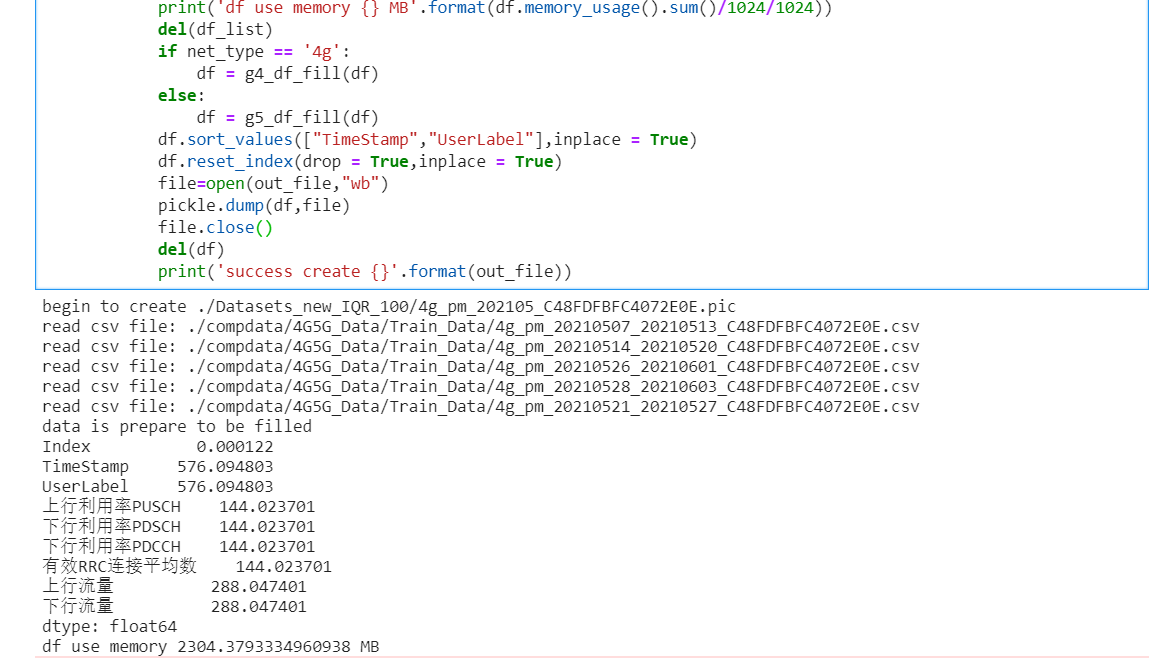

8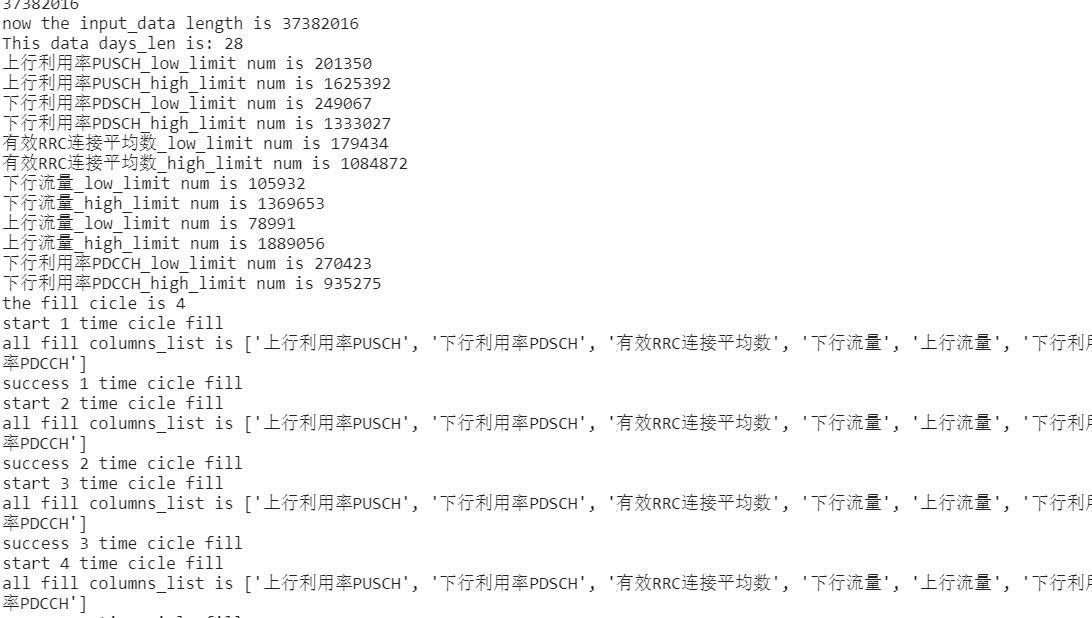

In [ ]:
end_time = datetime.datetime.now()
log_str = 'end_time is {}'.format(end_time)
print(log_str)
all_use_time = (end_time - start_time)
log_str = 'all_use_time is {}'.format(all_use_time)
print(log_str)

**the end time of code running and all use time is about 6 hours**
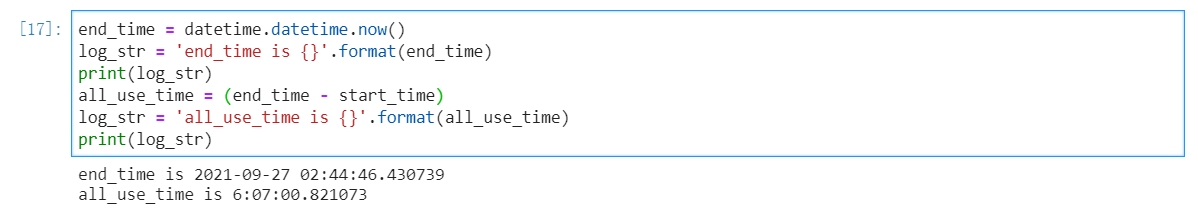